### IOS Smile Arch 에서 ROI 검색, 정렬, 정합 

In [1]:
import os
import numpy as np
import pyvista as pv
import time
import copy

랜덤하게 회전 시킨 모델을 불러옴 

In [2]:
model_path = "assets/data/transformed/transformed_model_20250408_091623.stl"

In [3]:
def align_with_obb(mesh, debug=False):
    """
    OBB 축을 기준으로 메쉬를 정렬합니다. 
    가장 짧은 축은 z축, 가장 긴 축은 x축, 중간 길이 축은 y축으로 정렬됩니다.
    
    구체적인 변환 과정:
    1. 메쉬 중심점(OBB 중심)을 원점으로 이동
    2. PCA를 통해 주축을 찾아 회전 행렬 계산
    3. 회전 행렬을 적용하여 메쉬 정렬
    
    Args:
        mesh: PyVista 메쉬
        debug: 디버깅 모드 (중간 과정 시각화)
        
    Returns:
        aligned_mesh: 정렬된 메쉬
        obb_center: OBB 중심점
        rotation_matrix: 회전 행렬
    """
    try:
        print("[로그] align_with_obb 함수 시작")
        # 메쉬 복사
        aligned_mesh = mesh.copy()
        
        # 메쉬 정점
        vertices = mesh.points
        print(f"[로그] 정점 개수: {len(vertices)}")
        
        # OBB 계산에 필요한 값 추출
        # 점들의 평균 계산 (OBB 중심)
        mean_pt = np.mean(vertices, axis=0)
        print(f"[로그] OBB 중심 좌표: {mean_pt}")
        
        # 평균을 중심으로 점들을 이동
        centered_pts = vertices - mean_pt
        print(f"[로그] 센터링 완료")
        
        # 공분산 행렬 계산
        cov = np.cov(centered_pts, rowvar=False)
        print(f"[로그] 공분산 행렬 계산 완료")
        
        # 고유값과 고유벡터 계산
        try:
            print(f"[로그] 고유값 계산 시작")
            eigvals, eigvecs = np.linalg.eigh(cov)
            print(f"[로그] 고유값: {eigvals}")
            print(f"[로그] 고유벡터 행렬 형태: {eigvecs.shape}")
        except Exception as e:
            print(f"[오류] 고유값 계산 중 오류 발생: {e}")
            raise
        
        # 고유값이 큰 순서대로 정렬 (주축 순서대로)
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        print(f"[로그] 정렬된 고유값: {eigvals}")
        
        # 고유값에 따라 축 정렬: 가장 큰 고유값 -> x축, 중간 -> y축, 가장 작은 -> z축
        rotation_matrix = eigvecs
        print(f"[로그] 회전 행렬 계산 완료")
        
        # 회전 변환 적용 (기존 좌표계에서 표준 좌표계로 변환)
        # 주의: centered_pts는 이미 중심이 원점으로 이동된 점들임
        transformed_vertices = np.dot(centered_pts, rotation_matrix)
        print(f"[로그] 정점 변환 완료")
        
        # 변환된 정점 적용
        aligned_mesh.points = transformed_vertices
        print(f"[로그] 변환된 메쉬 생성 완료")
        
        # 디버깅 모드: 변환 과정 시각화
        if debug:
            import matplotlib.pyplot as plt
            from mpl_toolkits.mplot3d import Axes3D
            
            fig = plt.figure(figsize=(15, 5))
            
            # 원본 메쉬 점 시각화
            ax1 = fig.add_subplot(131, projection='3d')
            ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='.', alpha=0.1)
            ax1.set_title('Original Mesh')
            ax1.set_xlabel('X')
            ax1.set_ylabel('Y')
            ax1.set_zlabel('Z')
            
            # 중심이 원점으로 이동된 점 시각화
            ax2 = fig.add_subplot(132, projection='3d')
            ax2.scatter(centered_pts[:, 0], centered_pts[:, 1], centered_pts[:, 2], c='g', marker='.', alpha=0.1)
            ax2.set_title('Centered Mesh')
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.set_zlabel('Z')
            
            # 회전 변환 후 점 시각화
            ax3 = fig.add_subplot(133, projection='3d')
            ax3.scatter(transformed_vertices[:, 0], transformed_vertices[:, 1], transformed_vertices[:, 2], c='r', marker='.', alpha=0.1)
            ax3.set_title('Rotated Mesh')
            ax3.set_xlabel('X')
            ax3.set_ylabel('Y')
            ax3.set_zlabel('Z')
            
            plt.tight_layout()
            plt.show()
        
        print(f"[로그] align_with_obb 함수 완료")
        return aligned_mesh, mean_pt, rotation_matrix
    except Exception as e:
        print(f"[오류] align_with_obb 함수에서 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        # 에러가 발생해도 기본값 반환
        return mesh.copy(), np.zeros(3), np.eye(3)

In [4]:
mesh = pv.read(model_path)

[로그] align_with_obb 함수 시작
[로그] 정점 개수: 82376
[로그] OBB 중심 좌표: [-18.22411  -43.330463 -31.39286 ]
[로그] 센터링 완료
[로그] 공분산 행렬 계산 완료
[로그] 고유값 계산 시작
[로그] 고유값: [ 27.87249952 191.66824448 305.24257299]
[로그] 고유벡터 행렬 형태: (3, 3)
[로그] 정렬된 고유값: [305.24257299 191.66824448  27.87249952]
[로그] 회전 행렬 계산 완료
[로그] 정점 변환 완료
[로그] 변환된 메쉬 생성 완료


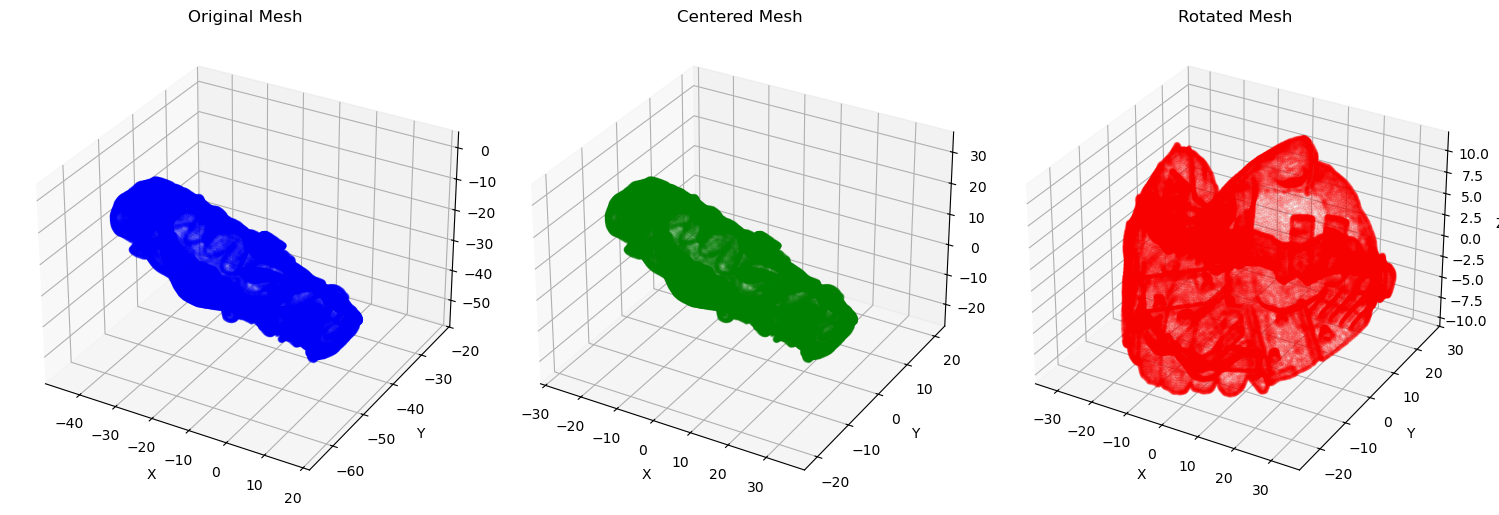

[로그] align_with_obb 함수 완료


In [5]:
aligned_mesh, obb_center, rotation_matrix = align_with_obb(mesh, debug=True)

In [6]:
obb_center

pyvista_ndarray([-18.22411 , -43.330463, -31.39286 ], dtype=float32)

In [7]:
transform_matrix_1 = np.eye(4)  # 4x4 단위 행렬 생성
transform_matrix_1[:3, :3] = rotation_matrix  # 회전 부분
transform_matrix_1[:3, 3] = obb_center  # 이동 부분

print("최종 변환 행렬:")
print(transform_matrix_1)

최종 변환 행렬:
[[ -0.82980402   0.50959242  -0.22746617 -18.22410965]
 [ -0.11676561  -0.55713057  -0.82217475 -43.33046341]
 [  0.54570237   0.65568369  -0.52181205 -31.39286041]
 [  0.           0.           0.           1.        ]]


In [8]:
def get_obb(mesh):
    """
    PyVista 메쉬의 OBB(Oriented Bounding Box)를 계산합니다.
    PCA 기반 방식으로 메쉬의 주축을 찾아 OBB를 계산합니다.
    
    Args:
        mesh: PyVista 메쉬
        
    Returns:
        pv.PolyData: OBB를 나타내는 PyVista 메쉬
    """
    vertices = mesh.points
    
    # 점들의 평균 계산 (OBB 중심)
    mean_pt = np.mean(vertices, axis=0)
    
    # 평균을 중심으로 점들을 이동
    centered_pts = vertices - mean_pt
    
    # 공분산 행렬 계산
    cov = np.cov(centered_pts, rowvar=False)
    
    # 고유값과 고유벡터 계산
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # 고유값이 큰 순서대로 정렬 (주축 순서대로)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    # OBB의 주축 (각 열이 하나의 축)
    obb_axes = eigvecs
    
    # 주축 방향으로 점들 투영
    projections = np.dot(centered_pts, obb_axes)
    
    # 각 축에 대한 최소/최대값 계산
    mins = np.min(projections, axis=0)
    maxs = np.max(projections, axis=0)
    
    # OBB의 크기 계산
    obb_extents = maxs - mins
    
    # 8개의 코너 좌표 계산
    half_sizes = obb_extents / 2
    corners_local = np.array([
        [-half_sizes[0], -half_sizes[1], -half_sizes[2]],
        [half_sizes[0], -half_sizes[1], -half_sizes[2]],
        [half_sizes[0], half_sizes[1], -half_sizes[2]],
        [-half_sizes[0], half_sizes[1], -half_sizes[2]],
        [-half_sizes[0], -half_sizes[1], half_sizes[2]],
        [half_sizes[0], -half_sizes[1], half_sizes[2]],
        [half_sizes[0], half_sizes[1], half_sizes[2]],
        [-half_sizes[0], half_sizes[1], half_sizes[2]]
    ])
    
    # 로컬 좌표를 월드 좌표로 변환
    corners = np.empty((8, 3))
    for i in range(8):
        corners[i] = mean_pt + np.dot(obb_axes, corners_local[i])
    
    # OBB 모서리 정의 (각 모서리는 두 코너 인덱스로 구성)
    edges = np.array([
        [0, 1], [1, 2], [2, 3], [3, 0],
        [4, 5], [5, 6], [6, 7], [7, 4],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ])
    
    # PyVista 메쉬 생성
    obb_mesh = pv.PolyData(corners)
    
    # 모서리 생성
    lines = np.hstack([[2, edge[0], edge[1]] for edge in edges])
    obb_mesh.lines = lines
    
    return obb_mesh


In [9]:
def align_y_direction(mesh, visualize=False):
    """
    무게중심이 OBB 중심의 +Y 방향에 오도록 메쉬를 회전시킵니다.
    
    Args:
        mesh: PyVista 메쉬
        visualize: 시각화 여부 (default: False)
        
    Returns:
        rotated_mesh: Y축 방향으로 정렬된 메쉬
        need_y_rotation: Y축 회전이 적용되었는지 여부
        center_diff: 정렬 전 OBB 중심과 무게중심의 차이
        rotated_center_diff: 정렬 후 OBB 중심과 무게중심의 차이
    """
    try:
        # 기존 코드...
        mesh_copy = mesh.copy()
        obb = get_obb(mesh_copy)
        weight_center = np.mean(mesh_copy.points, axis=0)
        obb_center = np.mean(obb.points, axis=0)
        center_diff = np.abs(weight_center) - np.abs(obb_center)
        
        # 시각화 코드 추가
        if visualize:
            import matplotlib.pyplot as plt
            
            fig = plt.figure(figsize=(15, 5))
    
            # 원본 메쉬 시각화
            ax1 = fig.add_subplot(131, projection='3d')
            # 메쉬 포인트 투명도 증가
            ax1.scatter(mesh_copy.points[:, 0], 
                    mesh_copy.points[:, 1], 
                    mesh_copy.points[:, 2], 
                    c='b', marker='.', alpha=0.01)  # alpha 0.1 -> 0.05로 감소
            # 중심점 크기 증가 및 투명도 감소
            ax1.scatter(weight_center[0], weight_center[1], weight_center[2], 
                    c='r', marker='*', s=300, alpha=1.0, label='Weight Center')  # 크기 증가, 별표 마커
            ax1.scatter(obb_center[0], obb_center[1], obb_center[2], 
                    c='g', marker='^', s=300, alpha=1.0, label='OBB Center')  # 크기 증가, 삼각형 마커
            ax1.set_title('Before Alignment')
            ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))  # 범례 위치 조정

            
        need_y_rotation = center_diff[1] < 0
        
        if need_y_rotation:
            z_rotation = np.array([
                [-1, 0, 0],
                [0, -1, 0],
                [0, 0, 1]
            ])
            mesh_copy.points = np.dot(mesh_copy.points, z_rotation)
            
            # 회전 후 중심점 재계산
            rotated_obb = get_obb(mesh_copy)
            rotated_weight_center = np.mean(mesh_copy.points, axis=0)
            rotated_obb_center = np.mean(rotated_obb.points, axis=0)
            rotated_center_diff = rotated_weight_center - rotated_obb_center
            
            # 회전 후 시각화
            if visualize:
                import pyvista as pv
                
                # 세 개의 서브플롯을 가진 플로터 생성
                pl = pv.Plotter(shape=(1, 3))
                
                # 1. 원본 메쉬 시각화
                pl.subplot(0, 0)
                pl.add_mesh(mesh_copy, 
                                color='lightblue', 
                                opacity=0.7, 
                                point_size=2, 
                                render_points_as_spheres=True,
                                label='Mesh')
                # 무게중심과 OBB 중심 표시
                center_cloud = pv.PolyData(weight_center)
                pl.add_mesh(center_cloud, 
                                color='red', 
                                point_size=15, 
                                render_points_as_spheres=True,
                                label='Weight Center')
                obb_center_cloud = pv.PolyData(obb_center)
                pl.add_mesh(obb_center_cloud, 
                                color='green', 
                                point_size=15, 
                                render_points_as_spheres=True,
                                label='OBB Center')
                pl.add_legend()
                pl.add_axes()
                pl.view_isometric()
                pl.set_background('white')
                pl.add_title("Original Mesh")
                
                # 2. 회전 후 메쉬 시각화
                pl.subplot(0, 1)
                pl.add_mesh(mesh_copy, 
                                color='lightblue', 
                                opacity=0.7, 
                                point_size=2, 
                                render_points_as_spheres=True,
                                label='Rotated Mesh')
                # 회전된 무게중심과 OBB 중심 표시
                rotated_weight_cloud = pv.PolyData(rotated_weight_center)
                pl.add_mesh(rotated_weight_cloud, 
                                color='red', 
                                point_size=15, 
                                render_points_as_spheres=True,
                                label='Weight Center')
                rotated_obb_cloud = pv.PolyData(rotated_obb_center)
                pl.add_mesh(rotated_obb_cloud, 
                                color='green', 
                                point_size=15, 
                                render_points_as_spheres=True,
                                label='OBB Center')
                pl.add_legend()
                pl.add_axes()
                pl.view_isometric()
                pl.set_background('white')
                pl.add_title("After Alignment")
                
                # 3. Y축 방향 벡터 시각화
                pl.subplot(0, 2)
                pl.add_mesh(mesh_copy, 
                                color='lightblue', 
                                opacity=0.3, 
                                point_size=2, 
                                render_points_as_spheres=True)
                # Y축 방향 벡터 표시
                arrow_length = np.ptp(mesh_copy.points, axis=0).max() * 0.5  # 메쉬 크기의 50%
                arrow = pv.Arrow(rotated_obb_center, 
                                direction=[0, 1, 0], 
                                scale=arrow_length)
                pl.add_mesh(arrow, 
                                color='green', 
                                label='Y Direction')
                pl.add_legend()
                pl.add_axes()
                pl.view_isometric()
                pl.set_background('white')
                pl.add_title("Y Direction Vector")
                
                # 창 크기 설정 및 표시
                pl.window_size = [1500, 500]
                pl.show()
                
        return mesh_copy, need_y_rotation, center_diff, rotated_center_diff
        
    except Exception as e:
        print(f"[Error] align_y_direction: {e}")
        import traceback
        traceback.print_exc()
        return mesh.copy(), False, np.zeros(3), np.zeros(3)

In [10]:
transformation_info = {}
transformation_info['obb_center'] = obb_center
transformation_info['rotation_matrix'] = rotation_matrix

Widget(value='<iframe src="http://localhost:53634/index.html?ui=P_0x2265b5b3370_0&reconnect=auto" class="pyvis…

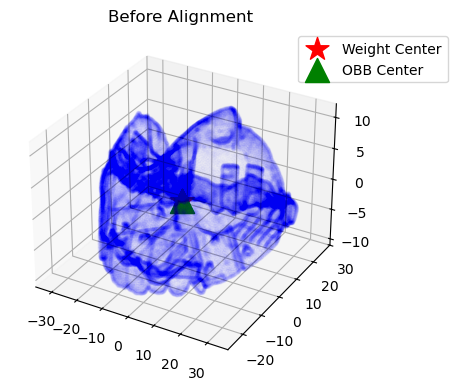

protocol.resume_writing() failed
protocol: <RequestHandler connected>
transport: <_SelectorSocketTransport fd=5048 read=polling write=<polling, bufsize=0>>
Traceback (most recent call last):
  File "c:\Users\right\miniconda3\envs\myenv\lib\asyncio\transports.py", line 300, in _maybe_resume_protocol
    self._protocol.resume_writing()
  File "c:\Users\right\miniconda3\envs\myenv\lib\site-packages\aiohttp\base_protocol.py", line 41, in resume_writing
    assert self._paused
AssertionError


In [11]:
y_aligned_mesh, need_y_rotation, center_diff, rotated_center_diff = align_y_direction(aligned_mesh, visualize=True)

In [12]:
need_y_rotation

np.True_

In [13]:
transformation_info['need_y_rotation'] = need_y_rotation
transformation_info['center_diff_before_y_rotation'] = center_diff
transformation_info['center_diff_after_y_rotation'] = rotated_center_diff
print("[로그] 통합 변환 - Y축 방향 정렬 완료")

[로그] 통합 변환 - Y축 방향 정렬 완료


In [14]:
def find_ray_mesh_intersection_approximate(mesh, ray_origin, ray_direction, max_distance_from_ray=0.01):
    """
    레이캐스팅 - 레이 위에 있는 점들 중에서 가장 먼 점을 찾음
    
    Args:
        mesh: PyVista 메쉬
        ray_origin: 레이 시작점
        ray_direction: 레이 방향 벡터
        max_distance_from_ray: 레이에서 고려할 최대 거리 (매우 작은 값 사용)
        
    Returns:
        edge_point: 레이 방향으로 가장 먼 외곽점
    """
    try:
        print(f"[로그] 레이캐스팅 함수 시작 (방향: {ray_direction})")
        vertices = mesh.points
        
        # 레이 방향 벡터 정규화
        ray_direction = ray_direction / np.linalg.norm(ray_direction)
        print(f"[로그] 정규화된 레이 방향: {ray_direction}")
        
        # 각 정점에서 레이 원점까지의 벡터
        vec_to_points = vertices - ray_origin
        
        # 레이 방향으로의 투영 거리 계산
        projections = np.dot(vec_to_points, ray_direction)
        print(f"[로그] 투영 거리 계산 완료: 최소={np.min(projections)}, 최대={np.max(projections)}")
        
        # 투영 값이 양수인 점만 선택 (레이 방향에 있는 점)
        valid_indices = np.where(projections > 0)[0]
        print(f"[로그] 유효한 점 개수: {len(valid_indices)}")
        
        if len(valid_indices) > 0:
            # 유효한 정점들
            valid_vertices = vertices[valid_indices]
            valid_projections = projections[valid_indices]
            
            # 레이에서 각 정점까지의 최단 거리 계산
            # 공식: ||(p - o) - ((p - o)·d)d|| 여기서 p는 정점, o는 레이 원점, d는 레이 방향 벡터
            projection_points = ray_origin + ray_direction.reshape(1, 3) * valid_projections.reshape(-1, 1)
            distances_from_ray = np.linalg.norm(valid_vertices - projection_points, axis=1)
            
            # 레이에 가까운 점만 고려 (정확히 레이 위에 있는 점을 찾기 위해 매우 작은 허용 오차 사용)
            near_ray_indices = np.where(distances_from_ray <= max_distance_from_ray)[0]
            
            if len(near_ray_indices) > 0:
                print(f"[로그] 레이 위/근처의 점 개수: {len(near_ray_indices)}")
                
                # 레이에 가까우면서 레이 방향으로 가장 먼 점 찾기
                filtered_indices = valid_indices[near_ray_indices]
                
                # 레이 방향으로 가장 먼 점의 인덱스
                max_proj_idx = filtered_indices[np.argmax(projections[filtered_indices])]
                edge_point = vertices[max_proj_idx]
                
                # 외곽점과 레이 원점 사이의 거리 계산
                distance_to_edge = np.linalg.norm(edge_point - ray_origin)
                print(f"[로그] 찾은 외곽점 좌표: {edge_point}")
                print(f"[로그] 원점에서 외곽점까지 거리: {distance_to_edge}")
                
                return edge_point
            else:
                print(f"[로그] 레이 위에 점이 없어 max_distance_from_ray를 증가시킵니다.")
                # 점이 없으면 거리 제한을 점진적으로 늘려가며 다시 시도
                for multiplier in [2, 5, 10, 20, 50]:
                    new_max_distance = max_distance_from_ray * multiplier
                    near_ray_indices = np.where(distances_from_ray <= new_max_distance)[0]
                    
                    if len(near_ray_indices) > 0:
                        print(f"[로그] 거리 {new_max_distance}로 {len(near_ray_indices)}개 점 발견")
                        filtered_indices = valid_indices[near_ray_indices]
                        max_proj_idx = filtered_indices[np.argmax(projections[filtered_indices])]
                        edge_point = vertices[max_proj_idx]
                        
                        # 외곽점과 레이의 거리 출력
                        closest_point_on_ray = ray_origin + ray_direction * np.dot(edge_point - ray_origin, ray_direction)
                        deviation = np.linalg.norm(edge_point - closest_point_on_ray)
                        print(f"[로그] 찾은 외곽점 좌표: {edge_point}")
                        print(f"[로그] 레이에서 외곽점까지 편차: {deviation}")
                        
                        return edge_point
                
                # 여전히 못찾으면 투영 거리가 가장 큰 점 선택
                print(f"[로그] 레이 근처에 점이 없어 투영 거리가 가장 큰 점 선택")
                max_proj_idx = valid_indices[np.argmax(projections[valid_indices])]
                edge_point = vertices[max_proj_idx]
                print(f"[로그] 투영 거리만 고려한 외곽점 좌표: {edge_point}")
                return edge_point
        
        print("[로그] 외곽점을 찾지 못했습니다.")
        return None
    except Exception as e:
        print(f"[오류] 레이캐스팅 중 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        return None

In [15]:
def align_to_edge_point(mesh, visualize=False):
    """
    +Y축 방향으로 레이캐스팅하여 외곽점을 찾습니다.
    
    Args:
        mesh: PyVista 메쉬
        visualize: 시각화 여부 (default: False)
        
    Returns:
        mesh: 원본 메쉬 (변경 없음)
        edge_point: 찾은 외곽점 좌표
    """
    try:
        print("[로그] align_to_edge_point 함수 시작")
        mesh_copy = mesh.copy()
        
        # 무게중심 계산
        weight_center = np.mean(mesh.points, axis=0)
        print(f"[로그] 무게중심 좌표: {weight_center}")
        
        # Y축 방향 레이 설정
        ray_origin = weight_center
        ray_direction = np.array([0, 1, 0])  # +Y 방향
        print(f"[로그] 레이 원점: {ray_origin}, 방향: {ray_direction}")
        
        # 모델 크기 계산
        model_size = np.ptp(mesh.points, axis=0).max()
        max_distance = model_size * 0.001
        print(f"[로그] 모델 크기: {model_size}, 초기 최대 거리: {max_distance}")
        
        edge_point = find_ray_mesh_intersection_approximate(mesh, ray_origin, ray_direction, max_distance)
        
        # 시각화 코드 추가
        if visualize:
            import pyvista as pv
            
            # 플로터 생성
            pl = pv.Plotter()
            
            # 메쉬 포인트 시각화
            pl.add_mesh(mesh_copy, 
                        color='lightblue', 
                        opacity=0.7, 
                        point_size=2, 
                        render_points_as_spheres=True,
                        label='Mesh')
            
            # 무게중심 표시
            center_cloud = pv.PolyData(weight_center)
            pl.add_mesh(center_cloud, 
                        color='red', 
                        point_size=15, 
                        render_points_as_spheres=True,
                        label='Weight Center')
            
            # 레이 방향 표시 (선으로 변경)
            ray_length = model_size * 0.5
            ray_end = weight_center + np.array([0, ray_length, 0])  # Y축 방향으로 연장
            ray_line = pv.Line(weight_center, ray_end)
            pl.add_mesh(ray_line, 
                        color='green', 
                        line_width=3,
                        label='Ray Direction')
            
            # 외곽점 표시
            if edge_point is not None:
                edge_cloud = pv.PolyData(edge_point)
                pl.add_mesh(edge_cloud, 
                        color='yellow', 
                        point_size=15, 
                        render_points_as_spheres=True,
                        label='Edge Point')
                
                # 무게중심에서 외곽점까지 선 표시
                line = pv.Line(weight_center, edge_point)
                pl.add_mesh(line, 
                        color='blue', 
                        line_width=3, 
                        opacity=0.5,
                        label='Ray Path')
            
            # 축, 범례, 배경 설정
            pl.add_axes()
            pl.add_legend(bcolor='white')
            pl.set_background('white')
            
            # 기본 뷰를 등각 투영으로 설정
            pl.camera_position = 'iso'
            
            # 창 크기 설정 및 제목 추가
            pl.window_size = [1000, 800]
            pl.add_title("Edge Point Detection Visualization\n(Use mouse to rotate/zoom)", font_size=16)
            
            # 시각화 표시
            pl.show()
        
        if edge_point is not None:
            print(f"[로그] 외곽점을 찾았습니다: {edge_point}")
            return mesh_copy, edge_point
        else:
            print("[로그] 외곽점을 찾지 못했습니다. 원본 메쉬 반환")
            return mesh_copy, weight_center
            
    except Exception as e:
        print(f"[오류] align_to_edge_point 함수에서 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        return mesh.copy(), np.zeros(3)

In [16]:
_, edge_point = align_to_edge_point(y_aligned_mesh, visualize=True)  # 메쉬는 변경하지 않음, 외곽점만 구함

[로그] align_to_edge_point 함수 시작
[로그] 무게중심 좌표: [ 3.02876302e-06  3.04771128e-05 -2.75603662e-05]
[로그] 레이 원점: [ 3.02876302e-06  3.04771128e-05 -2.75603662e-05], 방향: [0 1 0]
[로그] 모델 크기: 64.58970794452179, 초기 최대 거리: 0.06458970794452179
[로그] 레이캐스팅 함수 시작 (방향: [0 1 0])
[로그] 정규화된 레이 방향: [0. 1. 0.]
[로그] 투영 거리 계산 완료: 최소=-26.430498489326244, 최대=24.17874919764022
[로그] 유효한 점 개수: 42151
[로그] 레이 위에 점이 없어 max_distance_from_ray를 증가시킵니다.
[로그] 거리 0.32294853972260895로 3개 점 발견
[로그] 찾은 외곽점 좌표: [ 0.11814985 23.55512715 -0.08052794]
[로그] 레이에서 외곽점까지 편차: 0.1429649730722621


Widget(value='<iframe src="http://localhost:53634/index.html?ui=P_0x2265b59a5f0_1&reconnect=auto" class="pyvis…

[로그] 외곽점을 찾았습니다: [ 0.11814985 23.55512715 -0.08052794]


In [17]:
transformation_info['edge_point'] = edge_point
print("[로그] 통합 변환 - 외곽점 찾기 완료")

[로그] 통합 변환 - 외곽점 찾기 완료


In [18]:
def transform_mesh(mesh):
    """
    메쉬를 변환하는 총괄 함수:
    1. OBB 축에 정렬
    2. 무게중심이 +Y 방향에 오도록 회전
    3. +Y 방향 외곽점을 찾지만 메쉬는 이동시키지 않음
    
    Args:
        mesh: PyVista 메쉬
        
    Returns:
        transformed_mesh: OBB 축 정렬 및 Y축 방향 정렬된 메쉬 (외곽점 기준 이동은 하지 않음)
        transformation_info: 변환 정보를 담은 딕셔너리 (최종 변환 행렬 포함)
    """
    try:
        print("[로그] transform_mesh 함수 시작")
        transformation_info = {}
        
        # 단계 1: OBB 축에 정렬
        print("[로그] 통합 변환 - OBB 축 정렬 시작")
        aligned_mesh, obb_center, rotation_matrix = align_with_obb(mesh)
        transformation_info['obb_center'] = obb_center
        transformation_info['rotation_matrix'] = rotation_matrix
        print("[로그] 통합 변환 - OBB 축 정렬 완료")

        # 단계 2: 무게중심이 +Y 방향에 오도록 회전
        print("[로그] 통합 변환 - Y축 방향 정렬 시작")
        y_aligned_mesh, need_y_rotation, center_diff, rotated_center_diff = align_y_direction(aligned_mesh)
        transformation_info['need_y_rotation'] = need_y_rotation
        transformation_info['center_diff_before_y_rotation'] = center_diff
        transformation_info['center_diff_after_y_rotation'] = rotated_center_diff
        print("[로그] 통합 변환 - Y축 방향 정렬 완료")

        # 단계 3: +Y 방향 외곽점을 찾기만 하고 메쉬는 이동시키지 않음
        print("[로그] 통합 변환 - +Y 방향 외곽점 찾기 시작")
        _, edge_point = align_to_edge_point(y_aligned_mesh)  # 메쉬는 변경하지 않음, 외곽점만 구함
        transformation_info['edge_point'] = edge_point
        print("[로그] 통합 변환 - 외곽점 찾기 완료")

        # -------------------------------------------------------------------------
        # 완전히 새로운 접근법: 원본 메쉬와 변환된 메쉬의 정점을 직접 이용해 변환 행렬 계산
        # -------------------------------------------------------------------------
        print("[로그] 새로운 방식으로 변환 행렬 계산 시작")
        try:
            # 원본 메쉬와 변환된 메쉬의 정점
            src_points = mesh.points
            dst_points = y_aligned_mesh.points
            
            # 최소 필요한 포인트 수 (여러 점 사용해서 정확도 향상)
            min_points = min(1000, len(src_points))
            
            # 포인트 샘플링 (모든 점을 다 사용하면 느려질 수 있음)
            step = max(1, len(src_points) // min_points)
            src_sample = src_points[::step]
            dst_sample = dst_points[::step]
            
            # 실제 사용한 샘플 수
            n_samples = len(src_sample)
            print(f"[로그] 변환 행렬 계산에 {n_samples}개 정점 사용")
            
            # 호모지니어스 좌표로 변환
            src_homogeneous = np.ones((n_samples, 4))
            src_homogeneous[:, :3] = src_sample
            
            # 최소 제곱법으로 변환 행렬 계산 (Ax = b 형태로 풀기)
            # 각 점 (x,y,z)에 대해 변환 행렬의 각 행을 계산
            
            # 준비: 큰 행렬 A와 b 구성
            A = np.zeros((n_samples * 3, 12))
            b = np.zeros(n_samples * 3)
            
            for i in range(n_samples):
                # 원본 점
                px, py, pz = src_sample[i]
                # 대상 점
                qx, qy, qz = dst_sample[i]
                
                # x' = m11*x + m12*y + m13*z + m14
                A[i*3, 0] = px
                A[i*3, 1] = py
                A[i*3, 2] = pz
                A[i*3, 3] = 1
                b[i*3] = qx
                
                # y' = m21*x + m22*y + m23*z + m24
                A[i*3+1, 4] = px
                A[i*3+1, 5] = py
                A[i*3+1, 6] = pz
                A[i*3+1, 7] = 1
                b[i*3+1] = qy
                
                # z' = m31*x + m32*y + m33*z + m34
                A[i*3+2, 8] = px
                A[i*3+2, 9] = py
                A[i*3+2, 10] = pz
                A[i*3+2, 11] = 1
                b[i*3+2] = qz
            
            # 최소 제곱법으로 풀기
            # x = (A^T A)^(-1) A^T b
            x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
            
            # 계산된 변환 행렬의 맞춤 오차 출력
            if len(residuals) > 0:
                avg_error = np.sqrt(np.sum(residuals) / n_samples)
                print(f"[로그] 변환 행렬 맞춤 평균 오차: {avg_error:.9f}")
            
            # 변환 행렬로 재구성
            transform_matrix = np.eye(4)
            transform_matrix[0, :] = x[0:4]
            transform_matrix[1, :] = x[4:8]
            transform_matrix[2, :] = x[8:12]
            
            # 변환 행렬 저장
            transformation_info['transform_matrix'] = transform_matrix
            
            # 검증: 샘플 포인트를 변환해서 실제 변환과 비교
            test_src = src_sample[:10]  # 처음 10개 포인트만 테스트
            test_dst = dst_sample[:10]
            
            # 샘플 포인트에 변환 행렬 적용
            test_homogeneous = np.ones((len(test_src), 4))
            test_homogeneous[:, :3] = test_src
            transformed = np.dot(test_homogeneous, transform_matrix.T)
            transformed = transformed[:, :3]  # 다시 3D 좌표로 변환
            
            # 실제 변환된 포인트와 비교
            errors = np.linalg.norm(transformed - test_dst, axis=1)
            max_error = np.max(errors)
            avg_error = np.mean(errors)
            print(f"[로그] 변환 검증: 평균 오차 = {avg_error:.9f}, 최대 오차 = {max_error:.9f}")
            
            print("[로그] 새로운 방식으로 변환 행렬 계산 완료")
            
        except Exception as e:
            print(f"[오류] 새로운 변환 행렬 계산 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()
            
            # 오류 발생 시 기존 방식으로 계산된 변환 행렬 사용
            print("[로그] 기존 방식으로 변환 행렬 계산")
            # OBB 정렬 변환 행렬
            T1 = np.eye(4)
            T1[:3, 3] = -obb_center
            
            R = np.eye(4)
            R[:3, :3] = rotation_matrix
            
            obb_transform = np.dot(R, T1)
            
            # Y축 방향 정렬 변환 행렬
            y_transform = np.eye(4)
            if need_y_rotation:
                y_transform[:3, :3] = np.array([
                    [-1, 0, 0],
                    [0, -1, 0],
                    [0, 0, 1]
                ])
            
            final_transform = np.dot(y_transform, obb_transform)
            transformation_info['transform_matrix'] = final_transform
            print("[로그] 기존 방식으로 변환 행렬 계산 완료")

        return y_aligned_mesh, transformation_info

    except Exception as e:
        print(f"[오류] transform_mesh 함수에서 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        # 에러가 발생해도 기본값 반환
        return mesh.copy(), {'transform_matrix': np.eye(4)}

In [19]:
transformed_mesh, transformation_info = transform_mesh(mesh)

[로그] transform_mesh 함수 시작
[로그] 통합 변환 - OBB 축 정렬 시작
[로그] align_with_obb 함수 시작
[로그] 정점 개수: 82376
[로그] OBB 중심 좌표: [-18.22411  -43.330463 -31.39286 ]
[로그] 센터링 완료
[로그] 공분산 행렬 계산 완료
[로그] 고유값 계산 시작
[로그] 고유값: [ 27.87249952 191.66824448 305.24257299]
[로그] 고유벡터 행렬 형태: (3, 3)
[로그] 정렬된 고유값: [305.24257299 191.66824448  27.87249952]
[로그] 회전 행렬 계산 완료
[로그] 정점 변환 완료
[로그] 변환된 메쉬 생성 완료
[로그] align_with_obb 함수 완료
[로그] 통합 변환 - OBB 축 정렬 완료
[로그] 통합 변환 - Y축 방향 정렬 시작
[로그] 통합 변환 - Y축 방향 정렬 완료
[로그] 통합 변환 - +Y 방향 외곽점 찾기 시작
[로그] align_to_edge_point 함수 시작
[로그] 무게중심 좌표: [ 3.02876302e-06  3.04771128e-05 -2.75603662e-05]
[로그] 레이 원점: [ 3.02876302e-06  3.04771128e-05 -2.75603662e-05], 방향: [0 1 0]
[로그] 모델 크기: 64.58970794452179, 초기 최대 거리: 0.06458970794452179
[로그] 레이캐스팅 함수 시작 (방향: [0 1 0])
[로그] 정규화된 레이 방향: [0. 1. 0.]
[로그] 투영 거리 계산 완료: 최소=-26.430498489326244, 최대=24.17874919764022
[로그] 유효한 점 개수: 42151
[로그] 레이 위에 점이 없어 max_distance_from_ray를 증가시킵니다.
[로그] 거리 0.32294853972260895로 3개 점 발견
[로그] 찾은 외곽점 좌표: [ 0.11814985 23.55512715 

In [20]:
transformation_info['transform_matrix'] 

array([[  0.82980402,   0.1167656 ,  -0.54570238,   3.05078864],
       [ -0.50959242,   0.55713057,  -0.65568369,  -5.72992886],
       [ -0.22746617,  -0.82217475,  -0.52181205, -56.1517543 ],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

### 여기까지 변환행렬의 결과를 보자 

In [21]:
import pyvista as pv
import numpy as np

def visualize_transformation(mesh, transform_matrix):
    """
    원본 메쉬와 변환된 메쉬를 나란히 시각화합니다.
    그리드와 좌표계를 포함합니다.
    
    Args:
        mesh: 원본 PyVista 메쉬
        transform_matrix: 4x4 변환 행렬
    """
    # 메쉬 복사
    transformed_mesh = mesh.copy()
    
    # 변환 행렬 적용
    points = mesh.points
    homogeneous_points = np.ones((len(points), 4))
    homogeneous_points[:, :3] = points
    transformed_points = np.dot(homogeneous_points, transform_matrix.T)
    transformed_mesh.points = transformed_points[:, :3]
    
    # 플로터 생성 (2개의 창)
    pl = pv.Plotter(shape=(1, 2))
    
    # 메쉬의 크기 계산 (바운딩 박스 기준)
    bounds = mesh.bounds  # [xmin, xmax, ymin, ymax, zmin, zmax]
    sizes = np.array([bounds[1]-bounds[0], bounds[3]-bounds[2], bounds[5]-bounds[4]])
    grid_size = np.max(sizes) * 1.5
    grid_density = 10  # 그리드 라인의 개수
    
    # 원본 메쉬 표시 (왼쪽)
    pl.subplot(0, 0)
    # XY 그리드 (바닥)
    grid = pv.Plane(i_size=grid_size, j_size=grid_size, i_resolution=grid_density, j_resolution=grid_density)
    pl.add_mesh(grid, color='lightgray', opacity=0.3, line_width=1)
    # XZ 그리드 (뒤)
    grid_xz = grid.copy().rotate_x(90, inplace=False)
    pl.add_mesh(grid_xz, color='lightgray', opacity=0.3, line_width=1)
    # YZ 그리드 (옆)
    grid_yz = grid.copy().rotate_y(90, inplace=False)
    pl.add_mesh(grid_yz, color='lightgray', opacity=0.3, line_width=1)
    
    # 원본 메쉬 추가
    pl.add_mesh(mesh, color='lightblue', opacity=0.7, 
                show_edges=True, line_width=1,
                label='Original Mesh')
    
    # 좌표계 추가
    pl.add_axes(xlabel='X', ylabel='Y', zlabel='Z', 
                line_width=3, labels_off=False,
                x_color='red', y_color='green', z_color='blue')
    pl.add_title('Original Mesh')
    
    # 변환된 메쉬 표시 (오른쪽)
    pl.subplot(0, 1)
    # 그리드 추가
    pl.add_mesh(grid, color='lightgray', opacity=0.3, line_width=1)
    pl.add_mesh(grid_xz, color='lightgray', opacity=0.3, line_width=1)
    pl.add_mesh(grid_yz, color='lightgray', opacity=0.3, line_width=1)
    
    # 변환된 메쉬 추가
    pl.add_mesh(transformed_mesh, color='lightgreen', opacity=0.7,
                show_edges=True, line_width=1,
                label='Transformed Mesh')
    
    # 좌표계 추가
    pl.add_axes(xlabel='X', ylabel='Y', zlabel='Z', 
                line_width=3, labels_off=False,
                x_color='red', y_color='green', z_color='blue')
    pl.add_title('Transformed Mesh')
    
    # 범례 추가
    pl.subplot(0, 0)
    pl.add_legend()
    pl.subplot(0, 1)
    pl.add_legend()
    
    # 배경색 설정
    pl.set_background('white')
    
    # 창 크기 설정
    pl.window_size = [1600, 800]
    
    # 두 뷰포트의 카메라 위치 동기화
    pl.camera_position = 'iso'
    pl.link_views()
    
    # 제목 추가
    pl.add_text("Original vs Transformed Mesh\nUse mouse to rotate/zoom (views are linked)", font_size=12)
    
    # 표시
    pl.show()

# 함수 호출
visualize_transformation(mesh, transformation_info['transform_matrix'])

Widget(value='<iframe src="http://localhost:53634/index.html?ui=P_0x2265b3e3d30_2&reconnect=auto" class="pyvis…

In [22]:
def select_region_by_angle(mesh, angle_range_x=(-25, 25), angle_range_z=(-5, 5), visualize=False):
    try:
        print(f"[로그] 각도 범위 기반 영역 선택 시작: X {angle_range_x}도, Z {angle_range_z}도")
        
        # 각도 범위의 최대 절대값 계산
        max_angle_x = max(abs(angle_range_x[0]), abs(angle_range_x[1]))
        max_angle_z = max(abs(angle_range_z[0]), abs(angle_range_z[1]))
        
        # 1. 기본 계산
        vertices = mesh.points
        weight_center = np.mean(vertices, axis=0)
        vectors = vertices - weight_center
        norms = np.linalg.norm(vectors, axis=1)
        norms[norms == 0] = 1.0
        normalized_vectors = vectors / norms.reshape(-1, 1)
        
        # 2. 양의 Y 방향 점 선택
        y_components = normalized_vectors[:, 1]
        positive_y_indices = np.where(y_components > 0)[0]
        
        if len(positive_y_indices) == 0:
            print("[로그] 양의 Y 방향에 점이 없습니다.")
            return np.zeros(len(vertices), dtype=bool)
            
        # 3. 각도 기반 선택
        in_range = np.zeros(len(vertices), dtype=bool)
        
        for idx in positive_y_indices:
            direction = normalized_vectors[idx]
            
            if direction[1] < 0.2:
                continue
                
            xy_proj = np.array([direction[0], direction[1], 0])
            xy_norm = np.linalg.norm(xy_proj)
            
            if xy_norm > 1e-6:
                xy_proj_norm = xy_proj / xy_norm
                angle_x = np.degrees(np.arctan2(xy_proj_norm[1], xy_proj_norm[0]) - np.pi/2)
                if angle_x < -90:
                    angle_x += 360
                angle_x = abs(angle_x)
                
                yz_proj = np.array([0, direction[1], direction[2]])
                yz_norm = np.linalg.norm(yz_proj)
                
                if yz_norm > 1e-6:
                    yz_proj_norm = yz_proj / yz_norm
                    angle_z = np.degrees(np.arctan2(yz_proj_norm[1], yz_proj_norm[2]) - np.pi/2)
                    if angle_z < -90:
                        angle_z += 360
                    angle_z = abs(angle_z)
                    
                    x_in_range = angle_x <= max_angle_x
                    z_in_range = angle_z <= max_angle_z
                    
                    if x_in_range and z_in_range:
                        in_range[idx] = True
        
        # 4. 시각화
        if visualize:
            import matplotlib.pyplot as plt
            
            fig = plt.figure(figsize=(15, 5))
            
            # 정면도 (XY 평면)
            ax1 = fig.add_subplot(131, projection='3d')
            # 선택되지 않은 영역 (회색)
            ax1.scatter(vertices[~in_range, 0], 
                       vertices[~in_range, 1], 
                       vertices[~in_range, 2], 
                       c='gray', marker='.', alpha=0.05, label='Unselected')
            # 선택된 영역 (빨간색)
            ax1.scatter(vertices[in_range, 0], 
                       vertices[in_range, 1], 
                       vertices[in_range, 2], 
                       c='r', marker='.', alpha=0.3, label='Selected')
            # 무게중심 표시
            ax1.scatter(weight_center[0], weight_center[1], weight_center[2], 
                       c='g', marker='*', s=300, alpha=1.0, label='Weight Center')
            
            # 각도 범위 시각화
            height = np.max(norms) * 1.2
            theta = np.linspace(-np.radians(max_angle_x), 
                              np.radians(max_angle_x), 100)
            x = height * np.tan(theta)
            y = np.ones_like(theta) * height
            ax1.plot(x + weight_center[0], 
                    y + weight_center[1], 
                    np.zeros_like(theta) + weight_center[2], 
                    'b--', alpha=0.5, label='Angle Range')
            
            ax1.set_title('Front View (XY)')
            ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
            
            # 측면도 (YZ 평면)
            ax2 = fig.add_subplot(132, projection='3d')
            ax2.view_init(elev=0, azim=-90)
            ax2.scatter(vertices[~in_range, 0], 
                       vertices[~in_range, 1], 
                       vertices[~in_range, 2], 
                       c='gray', marker='.', alpha=0.05)
            ax2.scatter(vertices[in_range, 0], 
                       vertices[in_range, 1], 
                       vertices[in_range, 2], 
                       c='r', marker='.', alpha=0.3)
            ax2.scatter(weight_center[0], weight_center[1], weight_center[2], 
                       c='g', marker='*', s=300, alpha=1.0)
            
            # Z 방향 각도 범위
            z = height * np.tan(np.linspace(-np.radians(max_angle_z), 
                                          np.radians(max_angle_z), 100))
            ax2.plot(np.zeros_like(z) + weight_center[0], 
                    y + weight_center[1], 
                    z + weight_center[2], 
                    'b--', alpha=0.5)
            
            ax2.set_title('Side View (YZ)')
            
            # 상면도 (XZ 평면)
            ax3 = fig.add_subplot(133, projection='3d')
            ax3.view_init(elev=90, azim=0)
            ax3.scatter(vertices[~in_range, 0], 
                       vertices[~in_range, 1], 
                       vertices[~in_range, 2], 
                       c='gray', marker='.', alpha=0.05)
            ax3.scatter(vertices[in_range, 0], 
                       vertices[in_range, 1], 
                       vertices[in_range, 2], 
                       c='r', marker='.', alpha=0.3)
            ax3.scatter(weight_center[0], weight_center[1], weight_center[2], 
                       c='g', marker='*', s=300, alpha=1.0)
            
            # 모든 축에 대해 동일한 스케일 설정
            ax1.set_box_aspect([1,1,0.2])
            ax3.set_box_aspect([1,1,0.2])
            
            plt.tight_layout(w_pad=3.0)
            plt.show()
        
        return in_range
        
    except Exception as e:
        print(f"[오류] select_region_by_angle 함수에서 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros(len(vertices), dtype=bool)

[로그] 각도 범위 기반 영역 선택 시작: X (-35, 35)도, Z (-5, 5)도


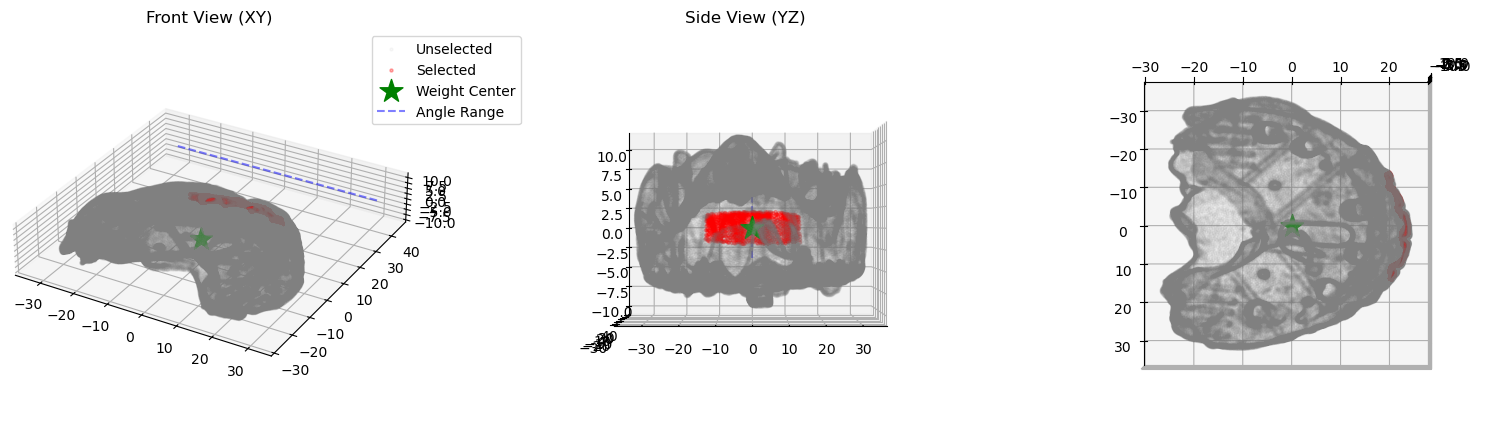

In [23]:
region_mask_final = select_region_by_angle(transformed_mesh, angle_range_x=(-35, 35), visualize=True)

In [24]:
def find_boundary_points(mesh, region_mask, n_neighbors=10):
    """
    선택된 영역(region_mask)에서 외곽 경계점들을 찾습니다.
    
    Args:
        mesh: PyVista 메쉬
        region_mask: 선택된 영역을 나타내는 불리언 마스크
        n_neighbors: 이웃 검색에 사용할 포인트 개수
        
    Returns:
        boundary_indices: 경계점 인덱스 목록
    """
    try:
        print("[로그] 경계점 추출 시작")
        # 영역에 해당하는 정점 인덱스
        region_indices = np.where(region_mask)[0]
        
        if len(region_indices) == 0:
            print("[로그] 선택된 영역에 정점이 없습니다.")
            return []
        
        vertices = mesh.points
        region_vertices = vertices[region_indices]
        
        # KDTree를 사용하여 각 정점의 주변 정점 찾기
        from scipy.spatial import KDTree
        tree = KDTree(vertices)
        
        # 경계점 목록
        boundary_indices = []
        
        for idx in region_indices:
            # 현재 정점 좌표
            point = vertices[idx]
            
            # 주변 정점 찾기
            distances, neighbors = tree.query(point, k=n_neighbors)
            
            # 주변 정점 중 영역 외부에 있는 정점이 있는지 확인
            has_outside_neighbor = False
            for neighbor_idx in neighbors:
                if neighbor_idx < len(region_mask) and not region_mask[neighbor_idx]:
                    has_outside_neighbor = True
                    break
            
            # 영역 외부에 있는 정점이 있으면 경계점으로 간주
            if has_outside_neighbor:
                boundary_indices.append(idx)
        
        print(f"[로그] 경계점 추출 완료: {len(boundary_indices)}개 발견")
        return boundary_indices
    
    except Exception as e:
        print(f"[오류] 경계점 추출 중 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        return []

In [25]:
boundary_indices_final = find_boundary_points(transformed_mesh, region_mask_final, n_neighbors=15)

[로그] 경계점 추출 시작
[로그] 경계점 추출 완료: 399개 발견


In [26]:
def region_growing(mesh, seed_indices, max_angle_diff=35.0, max_distance=None, visualize=False):
    """
    시드 포인트에서 시작하여 유사한 법선 방향을 가진 인접 정점으로 영역을 확장합니다.
    
    Args:
        mesh: PyVista 메쉬
        seed_indices: 시작점 인덱스 목록
        max_angle_diff: 법선 벡터 간 최대 허용 각도 차이 (도 단위)
        max_distance: 최대 거리 제한 (None이면 제한 없음)
        visualize: 시각화 여부
        
    Returns:
        grown_region: 확장된 영역을 나타내는 불리언 마스크
    """
    try:
        print("[로그] 영역 확장(Region Growing) 시작")
        vertices = mesh.points
        
        # 법선 벡터 계산
        print("[로그] 법선 벡터 계산 시작")
        try:
            if hasattr(mesh, 'point_data') and 'Normals' in mesh.point_data:
                normals = mesh.point_data['Normals']
                print("[로그] 메쉬에서 법선 벡터 정보 추출")
            else:
                mesh_copy = mesh.copy()
                mesh_copy.compute_normals(point_normals=True, cell_normals=False, inplace=True)
                if hasattr(mesh_copy, 'point_data') and 'Normals' in mesh_copy.point_data:
                    normals = mesh_copy.point_data['Normals']
                else:
                    print("[로그] 법선 직접 계산 시도")
                    normals = np.zeros_like(vertices)
                    for i in range(len(vertices)):
                        normal = vertices[i] - np.mean(vertices, axis=0)
                        norm = np.linalg.norm(normal)
                        if norm > 0:
                            normals[i] = normal / norm
                        else:
                            normals[i] = np.array([0, 1, 0])
                print("[로그] 법선 벡터 계산 완료")
        except Exception as e:
            print(f"[오류] 법선 벡터 계산 중 오류: {e}")
            normals = np.zeros_like(vertices)
            for i in range(len(vertices)):
                normal = vertices[i] - np.mean(vertices, axis=0)
                norm = np.linalg.norm(normal)
                if norm > 0:
                    normals[i] = normal / norm
                else:
                    normals[i] = np.array([0, 1, 0])
            print("[로그] 기본 법선 벡터 생성 완료")
        
        # 법선 벡터 정규화
        norms = np.linalg.norm(normals, axis=1)
        norms[norms == 0] = 1.0
        normals = normals / norms.reshape(-1, 1)
        
        # 거리 기준 설정
        if max_distance is None:
            max_distance = np.ptp(vertices, axis=0).max() * 0.02
            print(f"[로그] 최대 거리 기준 자동 설정: {max_distance}")
        
        # KDTree 설정
        from scipy.spatial import KDTree
        tree = KDTree(vertices)
        
        # 영역 확장 초기화
        grown_region = np.zeros(len(vertices), dtype=bool)
        if len(seed_indices) == 0:
            print("[로그] 시드 포인트가 없습니다. 빈 결과 반환.")
            return grown_region
            
        queue = list(seed_indices)
        in_queue = np.zeros(len(vertices), dtype=bool)
        in_queue[seed_indices] = True
        grown_region[seed_indices] = True
        
        # 시드 포인트들의 평균 법선 벡터
        avg_normal = np.mean(normals[seed_indices], axis=0)
        norm_avg = np.linalg.norm(avg_normal)
        if norm_avg > 0:
            avg_normal = avg_normal / norm_avg
        else:
            avg_normal = np.array([0, 1, 0])
        
        # 진행 상황을 저장할 리스트
        progress_states = []
        total_points = len(vertices)
        
        # 초기 상태 저장
        progress_states.append(grown_region.copy())
        
        # 영역 확장
        processed_count = 0
        target_points = max(1, total_points // 4)  # 전체 포인트의 1/4마다 상태 저장
        
        while queue:
            current_idx = queue.pop(0)
            processed_count += 1
            
            distances, neighbors = tree.query(vertices[current_idx], k=min(20, len(vertices)))
            
            for i, neighbor_idx in enumerate(neighbors):
                if neighbor_idx >= len(vertices) or grown_region[neighbor_idx] or in_queue[neighbor_idx]:
                    continue
                
                if distances[i] > max_distance:
                    continue
                
                neighbor_normal = normals[neighbor_idx]
                similarity = np.dot(avg_normal, neighbor_normal)
                angle_diff = np.degrees(np.arccos(np.clip(similarity, -1.0, 1.0)))
                
                if angle_diff <= max_angle_diff:
                    grown_region[neighbor_idx] = True
                    queue.append(neighbor_idx)
                    in_queue[neighbor_idx] = True
            
            # 진행 상태 저장 (4단계)
            if len(progress_states) < 4 and processed_count % target_points == 0:
                progress_states.append(grown_region.copy())
                print(f"[로그] 진행 상태 저장: {len(progress_states)}/4 ({processed_count} points processed)")
        
        # 최종 상태 저장
        progress_states.append(grown_region.copy())
        
        # 시각화
        if visualize:
            import matplotlib.pyplot as plt
            
            # 데이터의 실제 범위 계산
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()
            
            # 각 축의 범위 계산
            x_range = x_max - x_min
            y_range = y_max - y_min
            z_range = z_max - z_min
            
            fig = plt.figure(figsize=(20, 8))
            stages = ['Initial', '25%', '50%', '75%', 'Final']
            
            for idx, (state, stage) in enumerate(zip(progress_states, stages)):
                ax = fig.add_subplot(1, 5, idx+1, projection='3d')
                
                # 선택되지 않은 점들
                ax.scatter(vertices[~state, 0], 
                        vertices[~state, 1], 
                        vertices[~state, 2], 
                        c='lightgray', marker='.', alpha=0.1, label='Unselected')
                
                # 선택된 점들
                ax.scatter(vertices[state, 0], 
                        vertices[state, 1], 
                        vertices[state, 2], 
                        c='red', marker='.', alpha=0.5, label='Selected')
                
                # 시드 포인트
                ax.scatter(vertices[seed_indices, 0],
                        vertices[seed_indices, 1],
                        vertices[seed_indices, 2],
                        c='green', marker='*', s=200, label='Seeds')
                
                # 축 레이블
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.set_zlabel('Z')
                
                # 그리드 표시
                ax.grid(True)
                
                # 제목 설정
                ax.set_title(f'{stage}\n({np.sum(state)} points)')
                
                # 범례 표시 (첫 번째 그래프에만)
                if idx == 0:
                    ax.legend(loc='upper right')
                
                # -X 축 방향에서 보기
                ax.view_init(elev=0, azim=90)
                
                # 실제 데이터 범위에 맞춰 축 범위 설정
                center_x = (x_max + x_min) / 2
                center_y = (y_max + y_min) / 2
                center_z = (z_max + z_min) / 2
                
                # 가장 큰 범위를 기준으로 스케일 조정
                max_range = max(x_range, y_range, z_range)
                ax.set_xlim(center_x - max_range/2, center_x + max_range/2)
                ax.set_ylim(center_y - max_range/2, center_y + max_range/2)
                ax.set_zlim(center_z - max_range/2, center_z + max_range/2)
                
                # 또는 각 축의 실제 범위 사용
                # ax.set_xlim(x_min, x_max)
                # ax.set_ylim(y_min, y_max)
                # ax.set_zlim(z_min, z_max)
                
            plt.tight_layout(w_pad=3.0)
            plt.show()
                
            print(f"[로그] 영역 확장 완료: 총 {np.sum(grown_region)}개 정점 포함")
            return grown_region
        
    except Exception as e:
        print(f"[오류] 영역 확장(Region Growing) 중 예외 발생: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros(len(mesh.points), dtype=bool)

[로그] 영역 확장(Region Growing) 시작
[로그] 법선 벡터 계산 시작
[로그] 법선 벡터 계산 완료


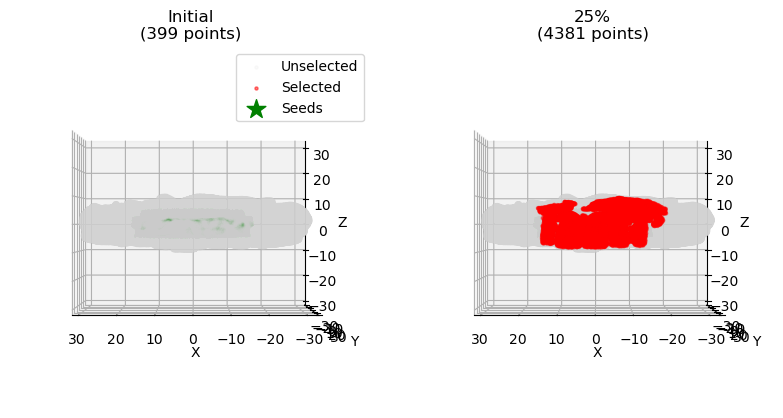

[로그] 영역 확장 완료: 총 4381개 정점 포함


In [27]:
grown_region_final = region_growing(transformed_mesh, boundary_indices_final, max_distance=30, visualize=True)

In [28]:
final_mask = np.logical_or(region_mask_final, grown_region_final)

In [29]:
final_mask_mesh = transformed_mesh.extract_points(final_mask)

In [30]:
def visualize_mask_position(transformed_mesh, final_mask_mesh):
    pl = pv.Plotter()
    
    # 원본 메쉬는 반투명 회색으로
    pl.add_mesh(transformed_mesh, color='gray', opacity=0.3, 
                show_edges=True, label='Full Mesh')
    
    # 마스크 메쉬는 빨간색으로
    pl.add_mesh(final_mask_mesh, color='red', opacity=0.7, 
                show_edges=True, label='Extracted Mask')
    
    pl.add_axes()
    pl.add_legend()
    pl.show()

visualize_mask_position(transformed_mesh, final_mask_mesh)

Widget(value='<iframe src="http://localhost:53634/index.html?ui=P_0x22611d03610_3&reconnect=auto" class="pyvis…

In [31]:
def normalize_mesh_position(mesh, edge_point, target=False):
    """
    메쉬의 위치를 정규화하고 변환 행렬을 반환합니다.
    
    Args:
        mesh: 정규화할 메쉬
        edge_point: 기준점
        target: target 메쉬인 경우 True (Z축 정규화 건너뜀)
        
    Returns:
        mesh_copy: 정규화된 메쉬
        transform_matrix: 4x4 변환 행렬
    """
    print(f"[로그] edge_point({edge_point})를 원점으로 이동")
    mesh_copy = copy.deepcopy(mesh)
    
    # 변환 행렬 초기화 (4x4 단위 행렬)
    transform_matrix = np.eye(4)
    
    # edge_point를 원점으로 이동
    mesh_copy.points = np.asarray(mesh_copy.points) - edge_point
    # 변환 행렬에 edge_point 이동 반영
    transform_matrix[0:3, 3] = -edge_point
    
    # source 메쉬의 경우에만 Z축 정규화 적용
    if not target:
        min_z = np.min(np.asarray(mesh_copy.points)[:, 2])
        print(f"[로그] Z축 최소값({min_z})을 0으로 이동")
        mesh_copy.points = np.asarray(mesh_copy.points) - np.array([0, 0, min_z])
        # 변환 행렬에 Z축 이동 추가
        transform_matrix[2, 3] -= min_z
    
    print("[로그] 변환 행렬:")
    print(transform_matrix)
    
    return mesh_copy, transform_matrix

In [32]:
print(final_mask_mesh)

UnstructuredGrid (0x22610ca6320)
  N Cells:    10444
  N Points:   5663
  X Bounds:   -1.958e+01, 1.592e+01
  Y Bounds:   1.379e+01, 2.418e+01
  Z Bounds:   -8.393e+00, 9.531e+00
  N Arrays:   2


In [33]:
final_mask_mesh, normalization_matrix = normalize_mesh_position(final_mask_mesh, edge_point)
transformed_mesh, normalization_matrix2 = normalize_mesh_position(transformed_mesh, edge_point)

[로그] edge_point([ 0.11814985 23.55512715 -0.08052794])를 원점으로 이동
[로그] Z축 최소값(-8.312400305459981)을 0으로 이동
[로그] 변환 행렬:
[[  1.           0.           0.          -0.11814985]
 [  0.           1.           0.         -23.55512715]
 [  0.           0.           1.           8.39292825]
 [  0.           0.           0.           1.        ]]
[로그] edge_point([ 0.11814985 23.55512715 -0.08052794])를 원점으로 이동
[로그] Z축 최소값(-9.499589235081404)을 0으로 이동
[로그] 변환 행렬:
[[  1.           0.           0.          -0.11814985]
 [  0.           1.           0.         -23.55512715]
 [  0.           0.           1.           9.58011717]
 [  0.           0.           0.           1.        ]]


In [34]:
# 기존 변환 행렬과 정규화 변환 행렬을 합침
final_transform = np.dot(normalization_matrix, transformation_info['transform_matrix'])

# 변환 행렬 업데이트
transformation_info['transform_matrix'] = final_transform

print("[로그] 최종 변환 행렬 (normalization * transform):")
print(final_transform)

[로그] 최종 변환 행렬 (normalization * transform):
[[  0.82980402   0.1167656   -0.54570238   2.93263879]
 [ -0.50959242   0.55713057  -0.65568369 -29.28505601]
 [ -0.22746617  -0.82217475  -0.52181205 -47.75882606]
 [  0.           0.           0.           1.        ]]


In [35]:
def visualize_3d_meshes(mask_mesh, full_mesh):
    """
    마스크 메쉬와 전체 메쉬를 3D 인터랙티브 뷰어로 시각화합니다.
    
    Args:
        mask_mesh: 선택된 영역의 메쉬
        full_mesh: 전체 메쉬
    """
    import pyvista as pv
    
    # PyVista 플로터 생성
    plotter = pv.Plotter()
    
    # 전체 메쉬 (회색, 반투명)
    plotter.add_mesh(full_mesh, 
                    color='gray', 
                    opacity=0.3, 
                    point_size=2, 
                    render_points_as_spheres=True,
                    label='Full Mesh')
    
    # 선택된 영역 (빨간색)
    plotter.add_mesh(mask_mesh, 
                    color='red', 
                    opacity=0.8, 
                    point_size=3,
                    render_points_as_spheres=True,
                    label='Selected Region')
    
    # 축 추가
    plotter.add_axes()
    
    # 범례 추가
    plotter.add_legend()
    
    # 배경색 설정 (흰색)
    plotter.set_background('white')
    
    # 카메라 위치 설정 (선택사항)
    # plotter.camera_position = 'xz'  # 다른 옵션: 'xy', 'yz', 'isometric'
    
    # 창 제목 설정
    plotter.window_size = [1000, 800]
    plotter.show(title="3D Mesh Visualization")

# 함수 호출
visualize_3d_meshes(final_mask_mesh, transformed_mesh)

Widget(value='<iframe src="http://localhost:53634/index.html?ui=P_0x22611d18dc0_4&reconnect=auto" class="pyvis…

In [36]:
targetMeshPath = "assets/library/smile_arch_origin.stl"

In [37]:
import open3d as o3d
import copy

def draw_registration_result_live1(vis, source_mesh, target_mesh, transformation=None, title="Mesh Visualization"):
    source_temp = copy.deepcopy(source_mesh)
    
    # 색상 설정
    source_temp.paint_uniform_color([1, 0, 0])  # 빨간색
    target_mesh.paint_uniform_color([0, 1, 0])  # 초록색
    
    if transformation is not None:
        source_temp.transform(transformation)
    
    # 법선 벡터 계산
    source_temp.compute_vertex_normals()
    target_mesh.compute_vertex_normals()
    
    # 시각화
    vis.clear_geometries()
    vis.add_geometry(source_temp)
    vis.add_geometry(target_mesh)
    
    # 기본 설정
    opt = vis.get_render_option()
    opt.mesh_show_back_face = True
    opt.light_on = True
    
    vis.update_renderer()
    #vis.update_window_title(title)
    
    return source_temp, target_mesh

# 메시 로드
source_mesh = o3d.io.read_triangle_mesh(model_path)
target_mesh = o3d.io.read_triangle_mesh(targetMeshPath)

# 시각화 창 생성
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mesh Visualization", width=1200, height=800)

# 초기 시각화
draw_registration_result_live1(vis, source_mesh, target_mesh, None, "Initial Mesh State")

# 실행
vis.run()
vis.destroy_window()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# transform_matrix_1 는 최초 정합을 하는 Transform Matrix

In [38]:
transform_matrix_1 = transformation_info.get('transform_matrix', np.eye(4))
print(transform_matrix_1)

[[  0.82980402   0.1167656   -0.54570238   2.93263879]
 [ -0.50959242   0.55713057  -0.65568369 -29.28505601]
 [ -0.22746617  -0.82217475  -0.52181205 -47.75882606]
 [  0.           0.           0.           1.        ]]


In [39]:
import open3d as o3d
target = o3d.io.read_triangle_mesh(targetMeshPath)

In [40]:
# Convert pyvista mesh to o3d mesh
vertices = final_mask_mesh.points
faces = final_mask_mesh.cells.reshape(-1, 4)[:, 1:4]  # Convert from pyvista format to o3d format

source = o3d.geometry.TriangleMesh()
source.vertices = o3d.utility.Vector3dVector(vertices)
source.triangles = o3d.utility.Vector3iVector(faces)

In [41]:
source_pcd = source.sample_points_uniformly(number_of_points=30000)
target_pcd = target.sample_points_uniformly(number_of_points=30000)

In [42]:
import open3d as o3d

# 포인트 클라우드 색상 설정
source_pcd.paint_uniform_color([1, 0, 0])    # 빨간색
target_pcd.paint_uniform_color([0, 1, 1])    # 파란색

# 두 포인트 클라우드를 함께 시각화
o3d.visualization.draw_geometries([source_pcd, target_pcd],
                                window_name="Point Clouds Visualization",
                                width=1200,
                                height=800,
                                point_show_normal=False)

In [43]:
voxel_size = 0.2
source_down = source_pcd.voxel_down_sample(voxel_size=voxel_size)
target_down = target_pcd.voxel_down_sample(voxel_size=voxel_size)

# 법선 벡터 계산
source_down.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))
target_down.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2, max_nn=30))

In [44]:
def align_to_occlusal_plane(pcd):
    """
    교합면을 기준으로 정렬하고 변환 행렬을 반환합니다.
    
    Returns:
        pcd: 정렬된 포인트 클라우드
        transform_matrix: 4x4 변환 행렬
    """
    points = np.asarray(pcd.points)
    y_max = np.max(points[:, 1])
    
    # 변환 행렬 생성
    transform_matrix = np.eye(4)
    transform_matrix[1, 3] = -y_max
    
    # 포인트 클라우드 이동
    pcd.translate([0, -y_max, 0])
    
    return pcd, transform_matrix

def get_principal_axes(pcd):
    """포인트 클라우드의 주축과 중심점을 계산합니다."""
    points = np.asarray(pcd.points)
    mean = np.mean(points, axis=0)
    centered = points - mean
    cov = np.cov(centered.T)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    # 주축 정렬 (큰 고유값 순서대로)
    idx = eigenvalues.argsort()[::-1]
    axes = eigenvectors[:, idx]
    return mean, axes

def align_heights(source, target):
    """
    소스와 타겟의 Z축 최저점을 맞춰 높이를 정렬합니다.
    
    Returns:
        source: 높이가 정렬된 소스 메쉬
        transform_matrix: 4x4 변환 행렬
    """
    source_points = np.asarray(source.points)
    target_points = np.asarray(target.points)
    
    # 각각의 최저 Z값 찾기
    source_z_min = np.min(source_points[:, 2])
    target_z_min = np.min(target_points[:, 2])
    
    # Z축 방향으로 이동하여 높이 맞추기
    translation = np.array([0, 0, target_z_min - source_z_min])
    
    # 변환 행렬 생성
    transform_matrix = np.eye(4)  # 4x4 단위 행렬
    transform_matrix[2, 3] = target_z_min - source_z_min  # Z축 이동
    
    # 메쉬 이동
    source.translate(translation)
    
    return source, transform_matrix

In [126]:
def draw_registration_result_live2(vis, source, target, transformation=None, title="Registration"):
    """실시간으로 정합 결과를 시각화합니다."""
    try:
        source_temp = copy.deepcopy(source)
        
        # 색상 설정
        source_temp.paint_uniform_color([1, 0, 0])  # 빨간색
        target.paint_uniform_color([0, 1, 0])       # 초록색
        
        # 변환 적용
        if transformation is not None:
            source_temp.transform(transformation)
        
        # 법선 벡터 추정 (PointCloud인 경우에만)
        if isinstance(source_temp, o3d.geometry.PointCloud):
            source_temp.estimate_normals()
            target.estimate_normals()
        
        # 시각화 업데이트
        vis.clear_geometries()
        vis.add_geometry(source_temp)
        vis.add_geometry(target)
        
        # 렌더링 옵션 설정
        opt = vis.get_render_option()
        opt.point_size = 2.0
        opt.background_color = [0, 0, 0]  # 검은색 배경
        
        # 카메라 설정 (고정된 뷰포인트)
        ctr = vis.get_view_control()
        ctr.set_front([0.0, 1.0, 1.0])  # 비스듬한 각도
        ctr.set_lookat([0, -14, 0])
        ctr.set_up([0, -1, 0])
        
        # 렌더링 업데이트
        vis.poll_events()
        vis.update_renderer()
        
        return source_temp
        
    except Exception as e:
        print(f"시각화 오류: {e}")
        return None

In [139]:
def fast_registration(source, target, vis=None):
    """주축 정렬을 사용한 빠른 정합을 수행하고 과정을 시각화합니다."""
    
    # 1. 교합면 정렬 (소스에만 적용)
    print("\n[1/5] 교합면 정렬 시작...")
    source, move_y_matrix = align_to_occlusal_plane(source)

    transformation_info['transform_matrix'] = np.dot(move_y_matrix, transformation_info['transform_matrix'])
    
    if vis is not None:
        print("  - 교합면 정렬 후 시각화 중...")
        draw_registration_result_live2(vis, source, target, None, "After Occlusal Alignment")
        time.sleep(0.2)
    
    # 2. Z축 높이 맞추기
    print("\n[2/5] Z축 높이 정렬 시작...")
    source, move_z_matrix = align_heights(source, target)
    transformation_info['transform_matrix'] = np.dot(move_z_matrix, transformation_info['transform_matrix'])
    
    if vis is not None:
        print("  - 높이 정렬 후 시각화 중...")
        draw_registration_result_live2(vis, source, target, None, "After Height Alignment")
        time.sleep(0.2)
    
    # 3. 초기 ICP 실행
    print("\n[3/5] 초기 ICP 시작...")
    current_transform = np.eye(4)
    last_fitness = 0
    for iteration in range(50):
        result = o3d.pipelines.registration.registration_icp(
            source, target,
            2.0,
            current_transform,
            o3d.pipelines.registration.TransformationEstimationPointToPlane(),
            o3d.pipelines.registration.ICPConvergenceCriteria(
                relative_fitness=1e-6,
                relative_rmse=1e-6,
                max_iteration=1
            )
        )
        
        if iteration % 100 == 0:  # 100번 반복마다 진행상황 출력
            print(f"  - 초기 ICP 반복 {iteration}: fitness = {result.fitness:.6f}")
        
        if np.allclose(result.transformation, current_transform, atol=1e-6):
            print(f"  - 초기 ICP 수렴 (반복 {iteration})")
            break
            
        current_transform = result.transformation
        
        if vis is not None:
            draw_registration_result_live2(vis, source, target, current_transform, f"Initial ICP - Iteration {iteration}")
            time.sleep(0.1)
    
    # 4. 중간 미세 조정
    print("\n[4/5] 중간 미세 조정 시작...")
    for iteration in range(50):
        result = o3d.pipelines.registration.registration_icp(
            source, target,
            0.5,
            current_transform,
            o3d.pipelines.registration.TransformationEstimationPointToPlane(),
            o3d.pipelines.registration.ICPConvergenceCriteria(
                relative_fitness=1e-7,
                relative_rmse=1e-7,
                max_iteration=1
            )
        )
        
        if iteration % 100 == 0:  # 100번 반복마다 진행상황 출력
            print(f"  - 중간 미세 조정 반복 {iteration}: fitness = {result.fitness:.6f}")
        
        if np.allclose(result.transformation, current_transform, atol=1e-7):
            print(f"  - 중간 미세 조정 수렴 (반복 {iteration})")
            break
            
        current_transform = result.transformation
        
        if vis is not None:
            draw_registration_result_live2(vis, source, target, current_transform, f"Intermediate Refinement - Iteration {iteration}")
            time.sleep(0.001)
    
    # 5. 최종 미세 조정
    print("\n[5/5] 최종 미세 조정 시작...")
    for iteration in range(50):
        result = o3d.pipelines.registration.registration_icp(
            source, target,
            0.2,
            current_transform,
            o3d.pipelines.registration.TransformationEstimationPointToPlane(),
            o3d.pipelines.registration.ICPConvergenceCriteria(
                relative_fitness=1e-8,
                relative_rmse=1e-8,
                max_iteration=1
            )
        )
        
        if iteration % 100 == 0:  # 100번 반복마다 진행상황 출력
            print(f"  - 최종 미세 조정 반복 {iteration}: fitness = {result.fitness:.6f}")
        
        if np.allclose(result.transformation, current_transform, atol=1e-8):
            print(f"  - 최종 미세 조정 수렴 (반복 {iteration})")
            break
            
        current_transform = result.transformation
        
        if vis is not None:
            draw_registration_result_live2(vis, source, target, current_transform, f"Final Refinement - Iteration {iteration}")
            time.sleep(0.001)
    
    if vis is not None:
        print("\n최종 결과 시각화 중...")
        draw_registration_result_live2(vis, source, target, current_transform, "Final Result")
        vis.run()
    
    print(f"\n정합 완료! 최종 fitness: {result.fitness:.6f}")
    return current_transform, result.fitness

In [140]:
transform_matrix_1 = transformation_info.get('transform_matrix', np.eye(4))
print(transform_matrix_1)

[[  0.82980402   0.1167656   -0.54570238   2.93263879]
 [ -0.50959242   0.55713057  -0.65568369 -29.90737817]
 [ -0.22746617  -0.82217475  -0.52181205 -47.76044687]
 [  0.           0.           0.           1.        ]]


In [ ]:
vis = o3d.visualization.Visualizer()
vis.create_window()

draw_registration_result_live2(vis, source_down, target_down, None, "Initial State")
time.sleep(1)

# 정합 실행
transform_matrix_2, best_fitness = fast_registration(source_down, target_down, vis)

# 결과 출력
print(f"\nFinal fitness: {best_fitness}")
print("\nTransformation matrix:")
print(transform_matrix_2)

print("\nRegistration completed. Press 'q' to exit...")

while True:
    if not vis.poll_events():
        break
    vis.update_renderer()
    time.sleep(0.1)
# 시각화 창 닫기
vis.destroy_window()


[1/5] 교합면 정렬 시작...
  - 교합면 정렬 후 시각화 중...

[2/5] Z축 높이 정렬 시작...
  - 높이 정렬 후 시각화 중...

[3/5] 초기 ICP 시작...
  - 초기 ICP 반복 0: fitness = 0.928543
  - 초기 ICP 반복 100: fitness = 0.951492

[4/5] 중간 미세 조정 시작...
  - 중간 미세 조정 반복 0: fitness = 0.670729

[5/5] 최종 미세 조정 시작...
  - 최종 미세 조정 반복 0: fitness = 0.368284


In [49]:
# 두 변환 행렬 합성
final_transform = np.matmul(transform_matrix_2, transform_matrix_1)

print("\n최종 변환 행렬:")
print(final_transform)



최종 변환 행렬:
[[  0.83681431   0.05352819  -0.54486379  -2.02256093]
 [ -0.44827857   0.63832823  -0.62576625 -24.08433797]
 [ -0.3143058   -0.76790091  -0.55815774 -50.5237143 ]
 [  0.           0.           0.           1.        ]]


In [50]:
import open3d as o3d
import copy

def draw_registration_result_live(vis, source_mesh, target_mesh, transformation=None, title="Mesh Visualization"):
    source_temp = copy.deepcopy(source_mesh)
    
    # 색상 설정
    source_temp.paint_uniform_color([1, 0, 0])  # 빨간색
    target_mesh.paint_uniform_color([0, 1, 0])  # 초록색
    
    if transformation is not None:
        source_temp.transform(transformation)
    
    # 법선 벡터 계산
    source_temp.compute_vertex_normals()
    target_mesh.compute_vertex_normals()
    
    # 시각화
    vis.clear_geometries()
    vis.add_geometry(source_temp)
    vis.add_geometry(target_mesh)
    
    # 기본 설정
    opt = vis.get_render_option()
    opt.mesh_show_back_face = True
    opt.light_on = True
    
    vis.update_renderer()
    #vis.update_window_title(title)
    
    return source_temp, target_mesh

# 메시 로드
source_mesh = o3d.io.read_triangle_mesh(model_path)
target_mesh = o3d.io.read_triangle_mesh(targetMeshPath)

# 시각화 창 생성
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mesh Visualization", width=1200, height=800)

# 초기 시각화
draw_registration_result_live(vis, source_mesh, target_mesh, None, "Initial Mesh State")

# 실행
vis.run()
vis.destroy_window()

In [51]:
source_temp = copy.deepcopy(source_mesh)
source_temp.transform(final_transform)

TriangleMesh with 492809 points and 164284 triangles.

In [52]:
# 시각화 창 생성
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mesh Visualization", width=1200, height=800)

# 초기 시각화
draw_registration_result_live(vis, source_temp, target_mesh, None, "Initial Mesh State")

# 실행
vis.run()
vis.destroy_window()

In [53]:
print(transform_matrix_1)

[[  0.82980402   0.1167656   -0.54570238   2.93263879]
 [ -0.50959242   0.55713057  -0.65568369 -29.28505601]
 [ -0.22746617  -0.82217475  -0.52181205 -47.75882606]
 [  0.           0.           0.           1.        ]]


In [54]:
transform_matrix_2

array([[ 0.99797559, -0.03935374,  0.04996002, -3.7157075 ],
       [ 0.04403355,  0.99437625, -0.09631678,  0.30691558],
       [-0.04588863,  0.09832171,  0.99409611, -0.03291963],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [55]:
transform_matrix_1 * transform_matrix_2

array([[ 8.28124157e-01, -4.59516278e-03, -2.72632995e-02,
        -1.08968279e+01],
       [-2.24391632e-02,  5.53997405e-01,  6.31533384e-02,
        -8.98804008e+00],
       [ 1.04381106e-02, -8.08376254e-02, -5.18731329e-01,
         1.57220304e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [56]:
source_temp = copy.deepcopy(source_mesh)
source_temp.transform(transform_matrix_2)

TriangleMesh with 492809 points and 164284 triangles.

In [57]:
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Mesh Visualization", width=1200, height=800)

# 초기 시각화
draw_registration_result_live(vis, source_temp, target_mesh, None, "Initial Mesh State")

# 실행
vis.run()
vis.destroy_window()